In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

In [3]:

def relu_n(x, n = 1):
    """ReLU activation clipped at n."""
    return tf.clip_by_value(x, 0, n)


In [4]:
class ExU(Layer):
    def __init__(self, units):
        super(ExU, self).__init__()
        self.units = units
        self._w_initializer = tf.initializers.TruncatedNormal(
          mean=4.0, stddev=0.5)
        
    def build(self, input_shape):
        # input_shape[-1] is the number of features
        self.w = self.add_weight(
            name="w",
            shape=(input_shape[-1], self.units),
            initializer=self._w_initializer,
            trainable=True
        )
        self.b = self.add_weight(
            name="b",
            shape=(1, self.units),
            # NOTE HERE I INCREASED THE STDDEV! FROM 0.5 to 1.5. THIS REALLY HELPED FIT THE EDGES!
            initializer=tf.initializers.TruncatedNormal(stddev=1.5),
            trainable=True
        )
        
    def call(self, inputs):
        
#         this tile is row_stack tf.shape(x)[0] times
        centre = tf.tile(self.b, [tf.shape(inputs)[0], 1])
        return relu_n(tf.math.exp(self.w) * (inputs - centre))
#         return tf.matmul(inputs, self.w) + self.b

In [70]:
class ExU_ND(Layer):
    def __init__(self, units):
        super(ExU_ND, self).__init__()
        self.units = units
        self._w_initializer = tf.initializers.TruncatedNormal(
          mean=4.0, stddev=0.5)
        
    def build(self, input_shape):
        # input_shape[-1] is the number of features
        self.w = self.add_weight(
            name="w",
            shape=(input_shape[-1], self.units),
            initializer=self._w_initializer,
            trainable=True
        )
        self.b = self.add_weight(
            name="b",
            shape=(1, self.units),
            # NOTE HERE I INCREASED THE STDDEV! FROM 0.5 to 1.5. THIS REALLY HELPED FIT THE EDGES!
            initializer=tf.initializers.TruncatedNormal(stddev=1.5),
            trainable=True
        )
        
    def call(self, inputs):
        
        c_pij = tf.transpose(inputs, perm=[0,1])[...,tf.newaxis] - self.b
        h = tf.reduce_sum(c_pij * tf.math.exp(self.w), axis=1)

        return relu_n(h)
#         return tf.matmul(inputs, self.w) + self.b

In [71]:
def plot_prediction_and_error(x, y, model=None, yhat=None):
    if model:
        yhat = model.predict(x)

    yRes = y - yhat
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    axes[0].plot(x, y)
    axes[0].plot(x, yhat)
    axes[1].plot(x, yRes)
    plt.show()
    plt.close()

In [72]:
def gen_test_data(stdev=0.1):
#     x = np.linspace(-np.pi/2., np.pi/2., 100)
    x = np.linspace(-1, 1, 100)[:,np.newaxis]
    y = np.cos(20*x) + np.sin(10*x)
#     y = np.cos(50*x) + np.sin(5*x)

    noise = np.random.normal(0, stdev, size=x.shape)

    return x, y + noise

x, y = gen_test_data(stdev=0.5)

In [73]:
import pugna.data

def preproc(data, method="MinMaxScaler", feature_range=(-1,1)):
    scalers = pugna.data.make_scalers(data, method=method, feature_range=feature_range)
    data_scaled = pugna.data.apply_scaler(data, scalers)
    return data_scaled, scalers

In [74]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import os



def resample_data(X, y, xmin=None, xmax=None, npts=1000, k=1):

    if xmin is None:
        xmin = X[0]
    if xmax is None:
        xmax = X[-1]
    mask = (X >= xmin) & (X <= xmax)

    iy = IUS(X[mask], y[mask], k=k)

    Xnew = np.linspace(xmin, xmax, npts)

    return Xnew, iy(Xnew)


def download_and_load_data():
    if os.path.exists("scaled_data_to_fit.txt") is False:
        os.system(
            "curl https://gitlab.com/SpaceTimeKhantinuum/ml/-/raw/master/nn-fitting/1d-fitting/scaled_data_to_fit.txt -O "
        )

    Xy = np.loadtxt("scaled_data_to_fit.txt")
    # sort by X
    X_raw, y_raw = Xy[np.argsort(Xy[:, 0])].T

    return X_raw, y_raw


x, y = download_and_load_data()

x, y = resample_data(x, y, xmin=None, xmax=None, npts=45, k=1)
# x, y = resample_data(x, y, xmin=None, xmax=None, npts=150, k=1)
# x, y = resample_data(x, y, xmin=None, xmax=None, npts=350, k=1)

x = x[:, np.newaxis]
y = y[:, np.newaxis]


x, x_val, y, y_val = train_test_split(x, y, test_size=0.25)

def sort_two_array_by_col(x, y, col):
    arr = np.column_stack((x, y))
    arr = arr[arr[:,col].argsort()]
    x = arr[:,0][:, np.newaxis]
    y = arr[:,1][:, np.newaxis]

    return x, y

x, y = sort_two_array_by_col(x, y, 0)
x_val, y_val = sort_two_array_by_col(x_val, y_val, 0)


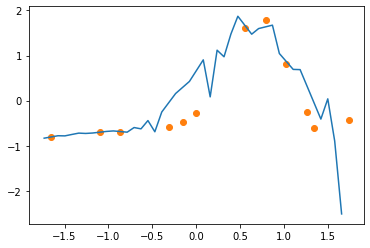

In [75]:
plt.figure()
plt.plot(x, y)
plt.scatter(x_val, y_val, c='C1')
plt.show()
plt.close()

In [77]:
def get_base_model(x, y, verbose=True, batch_size=None, epochs=1000, validation_data=None):
    if batch_size is None:
        batch_size = x.shape[0]
        
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),
#         ExU(2000),
        ExU_ND(2000),
#         tf.keras.layers.Dense(400, activation='tanh', bias_initializer=tf.initializers.TruncatedNormal(stddev=1.5)),
#         tf.keras.layers.Dense(400, activation='tanh', bias_initializer=tf.initializers.TruncatedNormal(stddev=1.5)),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.001, amsgrad=True)
    model.compile(loss='mse', optimizer=optimizer)
    
    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=validation_data)
    
    return history, model

In [78]:
def get_later_model(x, y, verbose=True, batch_size=None, epochs=1000, validation_data=None):
    if batch_size is None:
        batch_size = x.shape[0]

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),
        ExU(2000),
#         tf.keras.layers.Dense(600, activation='relu', bias_initializer=tf.initializers.TruncatedNormal(stddev=1.5)),
#         tf.keras.layers.Dense(600, activation='relu', bias_initializer=tf.initializers.TruncatedNormal(stddev=1.5)),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.001, amsgrad=True)
    model.compile(loss='mse', optimizer=optimizer)
    
    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=validation_data)
    
    return history, model

In [79]:
%%time
history1, model1 = get_base_model(x, y, epochs=500, validation_data=(x_val, y_val))

Epoch 1/500
1/1 [==============================] - 0s 63ms/step - loss: 1.0566 - val_loss: 0.4983
Epoch 2/500
1/1 [==============================] - 0s 23ms/step - loss: 0.7266 - val_loss: 0.4101
Epoch 3/500
1/1 [==============================] - 0s 20ms/step - loss: 0.4838 - val_loss: 0.3545
Epoch 4/500
1/1 [==============================] - 0s 20ms/step - loss: 0.3533 - val_loss: 0.2447
Epoch 5/500
1/1 [==============================] - 0s 26ms/step - loss: 0.2631 - val_loss: 0.2304
Epoch 6/500
1/1 [==============================] - 0s 28ms/step - loss: 0.2310 - val_loss: 0.2523
Epoch 7/500
1/1 [==============================] - 0s 31ms/step - loss: 0.2079 - val_loss: 0.2917
Epoch 8/500
1/1 [==============================] - 0s 28ms/step - loss: 0.2164 - val_loss: 0.3065
Epoch 9/500
1/1 [==============================] - 0s 25ms/step - loss: 0.2170 - val_loss: 0.3394
Epoch 10/500
1/1 [==============================] - 0s 21ms/step - loss: 0.2284 - val_loss: 0.3531
Epoch 11/500
1/1 [=

In [80]:
model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ex_u_nd (ExU_ND)             (None, 2000)              4000      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 2001      
Total params: 6,001
Trainable params: 6,001
Non-trainable params: 0
_________________________________________________________________


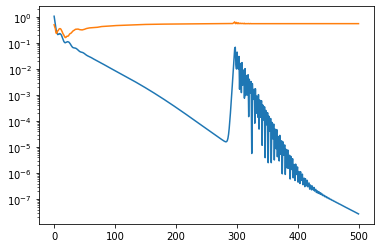

In [81]:
h1 = history1.history['loss']
h1_val = history1.history['val_loss']
plt.figure()
plt.plot(range(len(h1)), h1)
plt.plot(range(len(h1_val)), h1_val)
plt.yscale('log')

In [82]:
yhat = model1.predict(x)

In [83]:
yhat_val = model1.predict(x_val)

In [84]:
yRes = y-yhat 

In [85]:
yRes_val = y_val-yhat_val

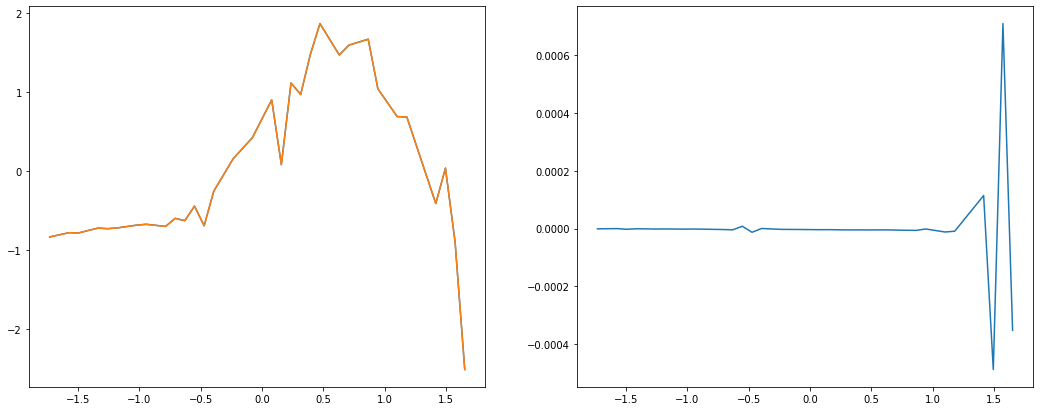

In [86]:
plot_prediction_and_error(x, y, model1)
# plot_prediction_and_error(x_val, y_val, model1)

(1e-18, 1)

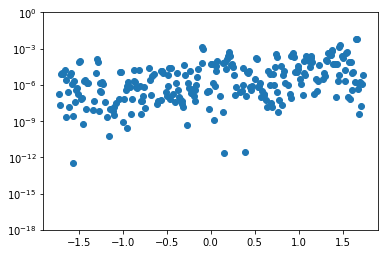

In [20]:
plt.figure()
plt.scatter(x, tf.keras.losses.mean_squared_error(y, yhat) )
plt.yscale('log')
plt.ylim(1e-18, 1)

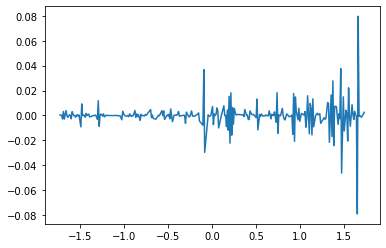

In [21]:
plt.figure()
plt.plot(x, yRes)

In [22]:
yRes, scalers2 = preproc(yRes)

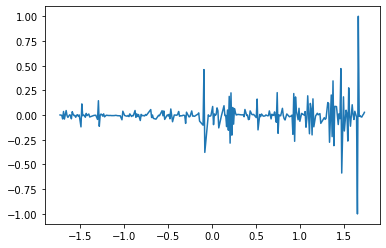

In [23]:
plt.figure()
plt.plot(x, yRes)

In [24]:
%%time
# history2, model2 = get_base_model(x, yRes, False, epochs=1000)
history2, model2 = get_later_model(x, yRes, False, epochs=3000)

CPU times: user 27.2 s, sys: 21.9 s, total: 49.1 s
Wall time: 10.9 s


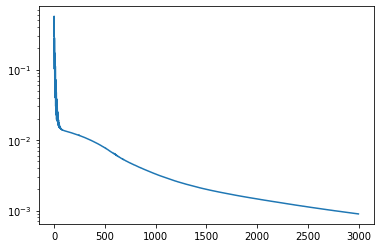

In [25]:
h2 = history2.history['loss']
plt.figure()
plt.plot(range(len(h2)), h2)
plt.yscale('log')

In [26]:
yhat2 = model2.predict(x)

In [27]:
yRes = pugna.data.apply_inverse_scaler(yRes, scalers2)
yhat2 = pugna.data.apply_inverse_scaler(yhat2, scalers2)

In [28]:
yRes2 = yRes-yhat2 

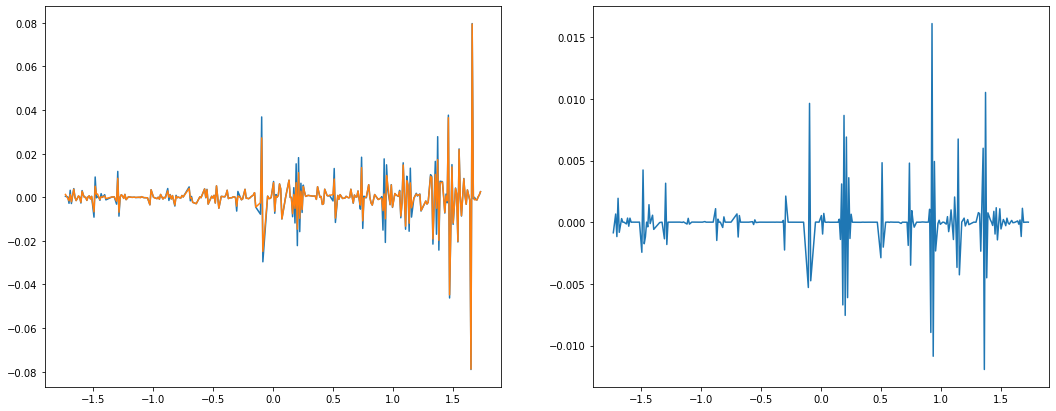

In [29]:
plot_prediction_and_error(x, yRes, yhat=yhat2) 

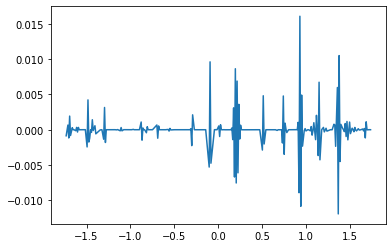

In [30]:
plt.figure()
plt.plot(x, yRes2)

In [31]:
yRes2, scalers3 = preproc(yRes2)

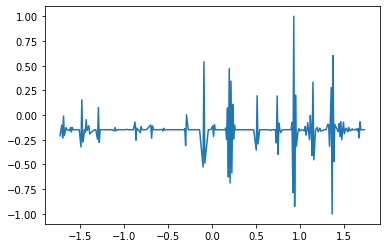

In [32]:
plt.figure()
plt.plot(x, yRes2)

In [33]:
%%time
history3, model3 = get_later_model(x, yRes2, False, epochs=4000)

CPU times: user 35.8 s, sys: 29.5 s, total: 1min 5s
Wall time: 14.4 s


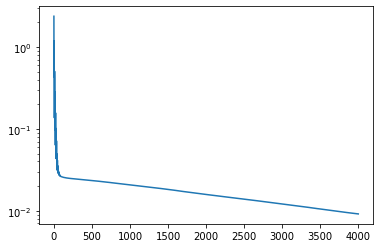

In [34]:
h3 = history3.history['loss']
plt.figure()
plt.plot(range(len(h3)), h3)
plt.yscale('log')

In [35]:
yhat3 = model3.predict(x)

In [36]:
yRes2 = pugna.data.apply_inverse_scaler(yRes2, scalers3)
yhat3 = pugna.data.apply_inverse_scaler(yhat3, scalers3)

In [37]:
yRes3 = yRes2-yhat3

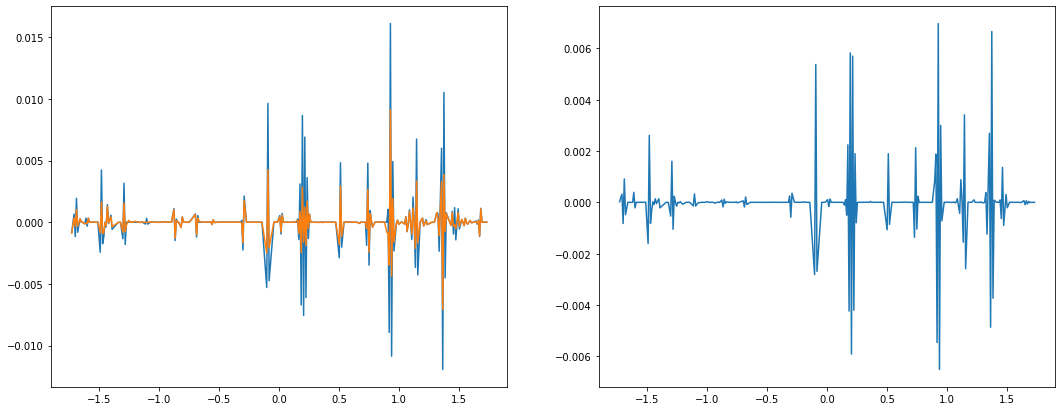

In [38]:
plot_prediction_and_error(x, yRes2, yhat=yhat3) 

In [39]:
# yhat_multistep = model1.predict(x) + model2.predict(x) # + model3.predict(x)
# yhat_multistep = model1.predict(x) + pugna.data.apply_inverse_scaler(model2.predict(x), scalers2)
yhat_multistep = model1.predict(x) \
    + pugna.data.apply_inverse_scaler(model2.predict(x), scalers2) \
    + pugna.data.apply_inverse_scaler(model3.predict(x), scalers3)


yhat_val_multistep = model1.predict(x_val) \
    + pugna.data.apply_inverse_scaler(model2.predict(x_val), scalers2) \
    + pugna.data.apply_inverse_scaler(model3.predict(x_val), scalers3)

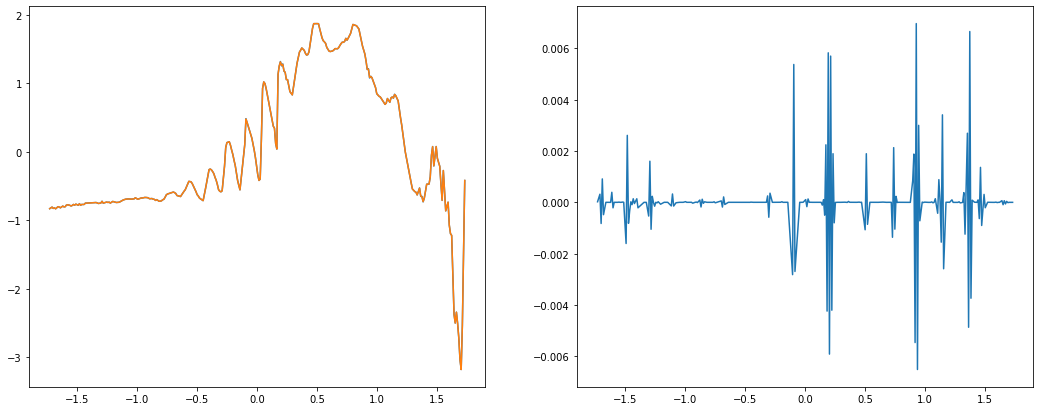

In [40]:
plot_prediction_and_error(x, y, model=None, yhat=yhat_multistep) 

In [41]:
yhat_multistep_loss = tf.keras.losses.mean_squared_error(y, yhat_multistep)
yhat_val_multistep_loss = tf.keras.losses.mean_squared_error(y_val, yhat_val_multistep)

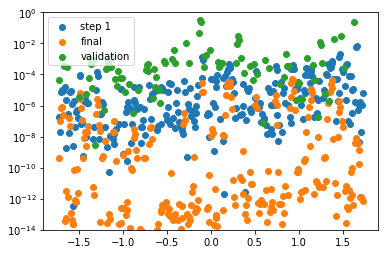

In [43]:
plt.figure()
plt.scatter(x, tf.keras.losses.mean_squared_error(y, yhat), label='step 1')
plt.scatter(x, yhat_multistep_loss, label='final')
plt.scatter(x_val, yhat_val_multistep_loss, label='validation')
plt.yscale('log')
plt.ylim(1e-14, 1)
plt.legend()